<a href="https://colab.research.google.com/github/Jaesu26/dacon-temp/blob/main/2024-04-08-%EB%AA%A8%EB%8D%B8-%ED%8A%9C%EB%8B%9D-%EC%B1%8C%EB%A6%B0%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 모델 튜닝 챌린지

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.0 MB/s eta 0:00:00


## 데이터 불러오기

In [239]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive

drive.mount("/content/drive")  # 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab Notebooks/모델-튜닝-챌린지

/content/drive/MyDrive/Colab Notebooks/모델-튜닝-챌린지


- 데이터 불러오기

In [203]:
df = pd.read_csv("./data/train.csv")
submission = pd.read_csv("./data/sample_submission.csv")

In [204]:
df.head(2)

,person_id,Sex,past_login_total,past_1_month_login,past_1_week_login,sub_size,email_type,phone_rat,apple_rat,login
0,0,0,3.0,1.0,1.0,0.0,0,0.000000,0.0,1
1,1,1,111.0,26.0,7.0,2.0,0,0.072072,0.0,1


In [205]:
df["login"].mean()

0.11153552330022919

`-` 로그인을 한 유저는 전체의 약 11% 이다

## 시각화

<Axes: xlabel='person_id'>

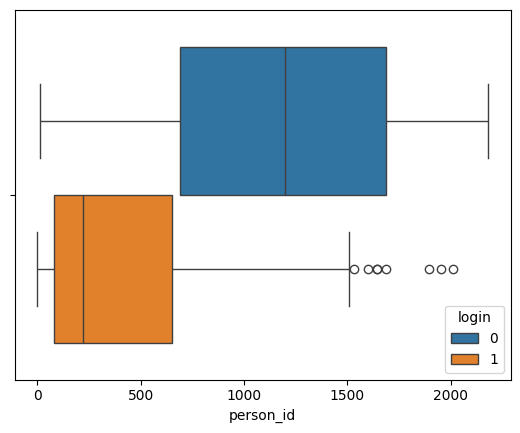

In [236]:
sns.boxplot(data=df, x="person_id", hue="login")

<Axes: xlabel='person_id', ylabel='Count'>

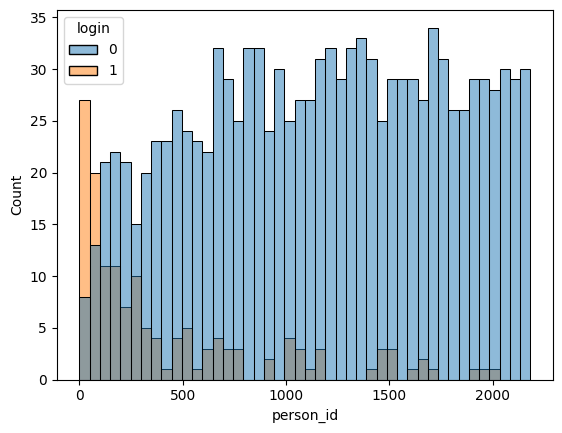

In [209]:
sns.histplot(data=df, hue="login", x="person_id", binwidth=50)

`-` 유저별 고유 아이디가 로그인 여부와 상관있어 보인다

`-` 로그인을 한 유저의 고유 아이디는 작은 쪽에 몰려있다

`-` 일반적으로 생각하기에 고유 아이디는 무작위성을 가진 변수로 로그인 여부와 관련이 있다고 불 수 없다

`-` 위와 같은 결과가 나온 이유는 우연이거나 고유 아이디가 무작위로 부여되지 않았기 때문일 것이다

`-` 만약 고유 아이디를 부여할 때 액티브 유저에게 우선적으로 번호를 배정했다면 고유 아이디가 작을 수록 로그인을 할 확률이 높으므로 위와 같은 결과가 나오는 것이 합리적이다

`-` 하지만 다른 변수를 고려하면 그렇지 않은 것 같다

In [214]:
df.query("person_id == 0")

,person_id,Sex,past_login_total,past_1_month_login,past_1_week_login,sub_size,email_type,phone_rat,apple_rat,login
0,0,0,3.0,1.0,1.0,0.0,0,0.0,0.0,1


`-` 고유 아이디가 0번인 유저를 살펴보자

`-` 총 로그인 횟수가 3번이며 제출 횟수는 0번이다

`-` 액티브한 유저에게 고유 아이디를 우선적으로 부여했다면 나오기 힘든 데이터이다

`-` 아니면 로그인 여부 변수와 관련이 있는 또 다른 기준으로 고유 아이디를 부여 했을 수도 있는데 이는 모순되는 데이터가 많아 합리적인 변수로 사용하긴 힘들다

<Axes: xlabel='sub_size'>

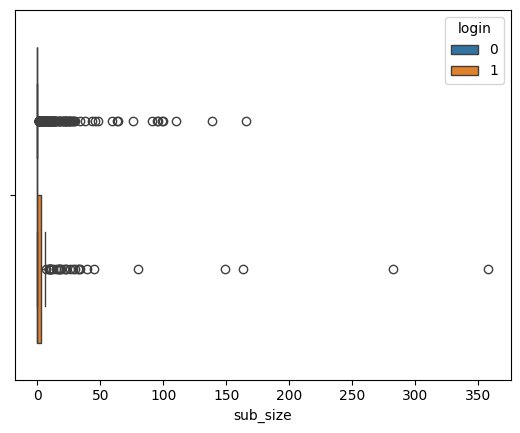

In [223]:
sns.boxplot(data=df, x="sub_size", hue="login")

`-` 과거에 제출을 많이 했더라도 현재는 데이콘에서 활동하지 않을 수 있다

`-` 반대로 새로운 액티브 유저의 경우 제출 횟수가 적을 수 밖에 없지만 로그인을 할 가능성이 높다

`-` 제출 횟수만 독단적으로 보기 보단 1달 전 로그인 여부, 1주 전 로그인 여부와 같은 변수와 함께 보는 것이 좋다

`-` 과거 총 로그인 횟수는 제출 횟수와 비슷한 성격을 가진 변수이므로 함께 보는 것이 적절하지 않을 수 있다

<Axes: xlabel='past_1_month_login'>

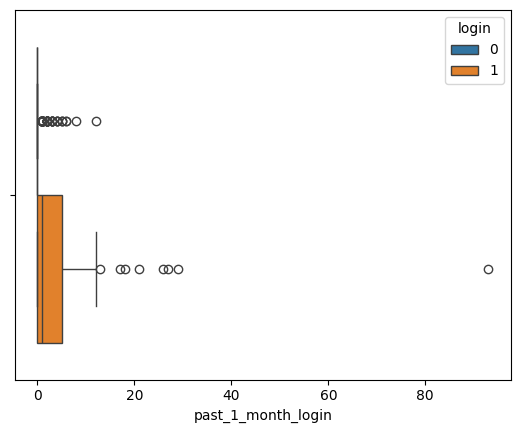

In [228]:
sns.boxplot(data=df, x="past_1_month_login", hue="login")

<Axes: xlabel='past_1_week_login'>

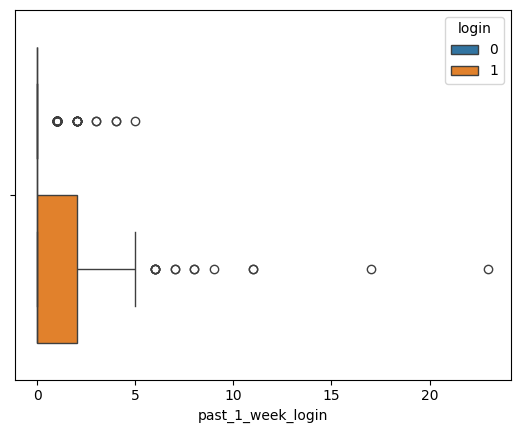

In [229]:
sns.boxplot(data=df, x="past_1_week_login", hue="login")

`-` 로그인을 한 사람이 과거에도 로그인을 한 가능성이 높다

`-` 그 외 변수는 로그인 여부와 큰 관련은 없다

## 전략

`-` 내가 모델을 튜닝할 때 유저별 고유 아이디 변수를 사용하지 않더라도 test 환경에서는 모든 변수와 데이터를 사용하여 학습하므로 의미가 없다

`-` 유저별 고유 아이디 변수가 로그인 여부와 실제로 관련이 있다면 상관 없지만 랜덤한 변수라면 영향을 덜 받도록 설계해야 한다

`-` 사용하는 변수 개수와 트리 개수를 낮추면 고유 아이디 변수의 영향을 최소화 할 수 있다

`-` 유저별 고유 아이디 변수, 유용한 변수 4개, 불필요한 변수 4개를 합해서 총 9개의 변수가 존재한다

`-` 적어도 하나의 유용한 변수를 포함시키기 위해선 6개의 변수를 사용하면 된다

`-` 5개의 변수를 사용할 경우 하나의 유용한 변수도 포함하지 않을 확률은 약 0.008이다 (3개일 경우 약 0.12이다)

`-` 꼭 6개 이상의 변수를 사용할 필요는 없고 다양성을 위해 더 적은 수의 변수를 사용해도 된다

`-` 단 변수 개수를 너무 낮추면 적합도가 떨어진다

`-` 붓스트랩을 사용하지 않고 램덤성을 변수 개수에만 부여한 후 교차 검증으로 auc 점수를 평가한다

`-` 하이퍼 파라미터 튜닝은 베이지안 튜닝 사용한다

## 하이퍼 파라미터 튜닝

In [237]:
SEED = 2024

In [242]:
X = df.loc[:, "person_id":"apple_rat"]
y = df["login"]

In [315]:
def objective(trial, X, y, seeds):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 50),
        "random_state": seeds[0],
        "bootstrap": trial.suggest_categorical("bootstrap", [False]),
        "max_depth" : trial.suggest_int("max_depth", 3, 8),
        "max_features": trial.suggest_int("max_features", 3, 6),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 6),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 6),
        "min_impurity_decrease": trial.suggest_float("min_impurity_decrease", 0.0, 0.05),
    }
    model = RandomForestClassifier(**params)
    total_scores = []
    for seed in seeds:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
        total_scores.extend(scores)
    mean_score = np.mean(total_scores)
    return mean_score

In [316]:
study = optuna.create_study(study_name="rf", direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(lambda trial: objective(trial, X, y, [SEED, SEED * 2]), n_trials=50)

[I 2024-04-07 17:06:40,286] A new study created in memory with name: rf
[I 2024-04-07 17:06:41,102] Trial 0 finished with value: 0.7833955431914796 and parameters: {'n_estimators': 50, 'bootstrap': False, 'max_depth': 6, 'max_features': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.010250947619714441}. Best is trial 0 with value: 0.7833955431914796.
[I 2024-04-07 17:06:41,911] Trial 1 finished with value: 0.7455282548621354 and parameters: {'n_estimators': 50, 'bootstrap': False, 'max_depth': 3, 'max_features': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.02241479122401523}. Best is trial 0 with value: 0.7833955431914796.
[I 2024-04-07 17:06:42,739] Trial 2 finished with value: 0.745535654595745 and parameters: {'n_estimators': 50, 'bootstrap': False, 'max_depth': 3, 'max_features': 6, 'min_samples_split': 5, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.033218432367823784}. Best is trial 0 with value: 0.783395543191479

In [318]:
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

Best Score: 0.8325549525906724
Best trial: {'n_estimators': 50, 'bootstrap': False, 'max_depth': 8, 'max_features': 3, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0006249322583502685}


In [319]:
for k, v in study.best_trial.params.items():
    submission[k] = v

In [320]:
submission

,n_estimators,criterion,max_depth,min_samples_split,min_samples_leaf,min_weight_fraction_leaf,max_features,max_leaf_nodes,min_impurity_decrease,bootstrap
0,50,gini,8,2,5,0,3,NaN,0.000625,False


## 제출

In [321]:
submission.to_csv("./data/submission-optuna-cv-final.csv", index=False)

`-` 점수는 0.780181962